In [1]:
import numpy as np
import torch
from random import seed
from os import listdir
from time import time
import matplotlib.pyplot as plt

from yoeo.main import get_dv2_model, get_upsampler_and_expr
from interactive_seg_backend.configs import FeatureConfig, TrainingConfig
from is_helpers import AllowedDatasets, eval_preds, get_pca_over_images_or_dir, get_and_cache_features_over_images, train_model_over_images, apply_model_over_images
    
from typing import Literal

SEED = 10672
seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = "cuda:1"

N CPUS: 110


In [2]:
dv2 = get_dv2_model(True, device=DEVICE)

model_path = "../trained_models/e5000_full_fit_reg.pth"
cfg_path = "../yoeo/models/configs/combined_no_shift.json"

upsampler, expr = get_upsampler_and_expr(model_path, cfg_path, device=DEVICE)

Using cache found in /home/ronan/.cache/torch/hub/ywyue_FiT3D_main


[128, 128, 128, 128]


In [3]:
SAVE: bool = False
PATH = "fig_data/is_benchmark"
AllowedDatasets = Literal["Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM"]
dataset: tuple[AllowedDatasets, ...] = ("Ni_superalloy_SEM", "T_cell_TEM", "Cu_ore_RLM")

chosen_dataset = "Ni_superalloy_SEM"
fnames = sorted(listdir(f"{PATH}/{chosen_dataset}/images/"))
images = [f"{PATH}/{chosen_dataset}/images/{fname}" for fname in fnames]

In [4]:
pca = get_pca_over_images_or_dir(images, dv2)

feat_cfg = FeatureConfig()
train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=True, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32,})
classical_train_cfg = TrainingConfig(feat_cfg, n_samples=-1, add_dino_features=False, classifier='xgb', classifier_params = {"class_weight": "balanced", "max_depth": 32,})

In [5]:
start_feat_t = time()
get_and_cache_features_over_images(chosen_dataset, train_cfg, '.tmp', PATH, dv2, upsampler, expr, pca)
end_feat_t = time()

In [6]:
TRAIN_IMG_FNAMES: dict[AllowedDatasets, list[str]] = {"Cu_ore_RLM": ["004", "028", "049", "077"], 
                                                      "Ni_superalloy_SEM": ["000", "001", "005", "007"], 
                                                      "T_cell_TEM": ["000", "005", "007", "026"]
                                                      }

In [7]:
base_labels = TRAIN_IMG_FNAMES[chosen_dataset] #["000", "001", "005", "007"]
all_label_paths = sorted(listdir(f"{PATH}/{chosen_dataset}/labels"))
all_label_fnames = [fname.split('.')[0] for fname in all_label_paths]

label_fnames = base_labels + [fname for fname in all_label_fnames if fname not in base_labels]

In [ ]:
start_sparse_train_apply_t = time()
selected_labels = TRAIN_IMG_FNAMES[chosen_dataset]
feat_paths = [f"{PATH}/.tmp/{name.split('.')[0]}.npy" for name in selected_labels]
classifier, _ = train_model_over_images(chosen_dataset, train_cfg, PATH, selected_labels , dv2, upsampler, expr, feat_paths, overwrite_with_gt=True)

all_feat_fnames = [f"{PATH}/.tmp/{fname}" for fname in sorted(listdir(f"{PATH}/.tmp"))]
sparse_deep_preds = apply_model_over_images(chosen_dataset, train_cfg, classifier, PATH, dv2, upsampler, expr, False, -1, pca, all_feat_fnames)
sparse_miou, sparse_std_miou = eval_preds(chosen_dataset, sparse_deep_preds, PATH)
print(f"(4/22): {sparse_miou:.4f} +/-{sparse_std_miou:.4f}")
end_sparse_train_apply_t = time()

(4/22): 0.7516 +/-0.1052


In [ ]:
start_full_train_apply_t = time()
selected_labels = TRAIN_IMG_FNAMES[chosen_dataset]
feat_paths = [f"{PATH}/.tmp/{name.split('.')[0]}.npy" for name in selected_labels]
classifier, _ = train_model_over_images(chosen_dataset, train_cfg, PATH, selected_labels , dv2, upsampler, expr, feat_paths, reveal_all=True)

all_feat_fnames = [f"{PATH}/.tmp/{fname}" for fname in sorted(listdir(f"{PATH}/.tmp"))]
full_deep_preds = apply_model_over_images(chosen_dataset, train_cfg, classifier, PATH, dv2, upsampler, expr, False, -1, pca, all_feat_fnames)
full_miou, full_std_miou = eval_preds(chosen_dataset, full_deep_preds, PATH)
print(f"(4/22): {full_miou:.4f} +/-{full_std_miou:.4f}")
end_full_train_apply_t = time()

(4/22): 0.7879 +/-0.1467


In [10]:
n_epochs = 200
out_dir = "fig_data/CNN_comparison/ni_superalloy/stored_CNN_results/"
cnn_full_data = np.load(f"{out_dir}/full_data_4_imgs_e{n_epochs}.npy", allow_pickle=True)
cnn_sparse_data = np.load(f"{out_dir}/sparse_data_4_imgs_e{n_epochs}.npy", allow_pickle=True)

In [28]:
cnn_full_times = [0] + [d["tot_time"] for d in cnn_full_data]
cnn_full_mious = [0] + [d["miou"] for d in cnn_full_data]
cnn_sparse_times = [0] +[d["tot_time"] for d in cnn_sparse_data]
cnn_sparse_mious = [0] +[d["miou"] for d in cnn_sparse_data]

In [29]:
sparse_t = (end_feat_t - start_feat_t) + (end_sparse_train_apply_t - start_sparse_train_apply_t)
full_t = (end_feat_t - start_feat_t) + (end_full_train_apply_t - start_full_train_apply_t)

In [43]:
deep_sparse_times = [0, sparse_t-0.1, sparse_t, cnn_sparse_times[-1]]
deep_sparse_mious = [0, 0, sparse_miou, sparse_miou]

deep_full_times = [0, full_t-0.1, full_t, cnn_full_times[-1]]
deep_full_mious = [0, 0, full_miou, full_miou]

save_per = 10
for i, t in enumerate(cnn_sparse_times):
    if t > sparse_t:
        sparse_train_to_idx = i
        break
sparse_train_to_epoch = (sparse_train_to_idx - 1) * save_per


for i, t in enumerate(cnn_full_times):
    if t > full_t:
        full_train_to_idx = i
        break
full_train_to_epoch = (full_train_to_idx - 1) * save_per

In [ ]:
results_dict, state = pmm_h.train_segmentation_model_with_eval(model, arch, encoder, train_ds, val_ds, values, 3, loss, n_epochs, save_per)

Text(0.5, 0, 'Time (s)')

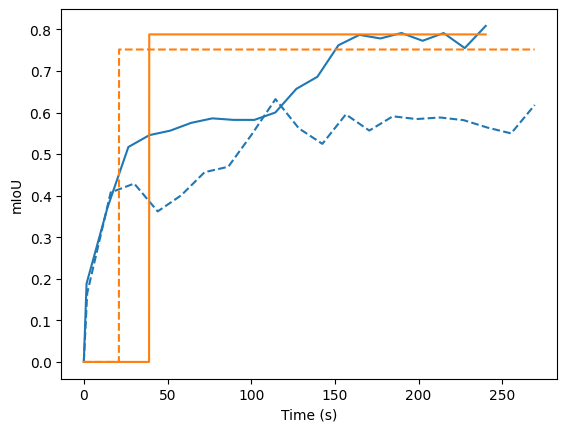

In [34]:
plt.plot(cnn_full_times, cnn_full_mious, color='C0', ls='-')
plt.plot(cnn_sparse_times, cnn_sparse_mious, color='C0', ls='--')

plt.plot(deep_full_times, deep_full_mious, color='C1', ls='-')
plt.plot(deep_sparse_times, deep_sparse_mious, color='C1', ls='--')

plt.ylabel('mIoU')
plt.xlabel('Time (s)')